<a href="https://colab.research.google.com/github/snassimr/CommonLit/blob/master/CommonLit_V13_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [4]:
SYS_PROJECT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit'
SYS_VERSION_DIR = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit/V12'
SYS_OUTPUT_DIR  = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit/V12'
SYS_LLM_DIR     = '/content/gdrive/MyDrive/Colab Notebooks/CommonLit/llm'

In [5]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.8 MB/s eta 0:00:00


In [6]:
import os
import pandas as pd
import shutil

In [7]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
# shutil.rmtree('test123')

In [9]:
# set random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(seed=42)

# Explore environment

In [11]:
# import psutil
# import platform
# uname = platform.uname()
# print(f"System: {uname.system}")  #Windows or Linux
# print(f"Node Name: {uname.node}") # System name
# print(f"Release: {uname.release}") # OS release version like  10(Windows) or 5.4.0-72-generic(linux)
# print(f"Version: {uname.version}")
# print(f"Machine: {uname.machine}")  # machine can be AMD64 or x86-64
# print(f"Processor: {uname.processor}") #  Intel64 Family 6 or x86_64
# print("Physical cores:", psutil.cpu_count(logical=False))
# print("Total cores:", psutil.cpu_count(logical=True))

# def get_size(bytes, suffix="B"):
#     """
#     Scale bytes to its proper format- KB, MB, GB, TB and PB
#     """
#     factor = 1024
#     for unit in ["", "K", "M", "G", "T", "P"]:
#         if bytes < factor:
#             return f"{bytes:.2f}{unit}{suffix}"
#         bytes /= factor

# print("Virtual memory")
# svmem = psutil.virtual_memory()
# print(f"Total: {get_size(svmem.total)}")
# print(f"Available: {get_size(svmem.available)}")
# print(f"Used: {get_size(svmem.used)}")

# Read Data

In [12]:
commonlit_texts = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'commonlit_texts.csv'))

def grade_to_text(grade):
    return "G" + str(grade)

commonlit_texts['grade'] = commonlit_texts['grade'].apply(grade_to_text)
commonlit_texts = commonlit_texts.drop_duplicates(subset='title', keep=False)
commonlit_texts['title'] = commonlit_texts['title'].str.replace('"', '').str.strip()

## Train Data

In [13]:
prompts_train   = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'prompts_train.csv'))
summaries_train = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'summaries_train.csv'))

In [14]:
print(f"Prompts train shape: {prompts_train.shape}")
display(prompts_train.head())
print(f"Summary train shape: {summaries_train.shape}")
display(summaries_train.head())

Prompts train shape: (4, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


Summary train shape: (7165, 5)


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [15]:
prompts_train = prompts_train.merge(commonlit_texts[['title', 'grade', 'genre']], how='left', left_on='prompt_title', right_on='title')
prompts_train['grade'] = prompts_train['grade'].fillna("G")
prompts_train['genre'] = prompts_train['genre'].fillna("Genre")

## Test Data

In [16]:
prompts_test   = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'prompts_test.csv'))
summaries_test = pd.read_csv(os.path.join(SYS_PROJECT_DIR,'summaries_test.csv'))

In [17]:
print(f"Prompts test shape: {prompts_test.shape}")
display(prompts_test.head())
print(f"Summary test shape: {summaries_test.shape}")
display(summaries_test.head())

Prompts test shape: (2, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


Summary test shape: (4, 3)


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [18]:
prompts_test = prompts_test.merge(commonlit_texts[['title', 'grade', 'genre']], how='left', left_on='prompt_title', right_on='title')
prompts_test['grade'] = prompts_test['grade'].fillna("G")
prompts_test['genre'] = prompts_test['genre'].fillna("Genre")

In [19]:
prompts_test

,prompt_id,prompt_question,prompt_title,prompt_text,title,grade,genre
0,abc123,Summarize...,Example Title 1,Heading\nText...,NaN,G,Genre
1,def789,Summarize...,Example Title 2,Heading\nText...,NaN,G,Genre


# Model Config

## Initialize Model_Config

In [18]:
Model_Config = {
    'model_name' : 'debertav3large',
    'base_model' : {
      # 'root_dir'      : 'debertav3base',
      # 'model_name'    : 'debertav3base',
      # 'num_labels'    : 1,
      'root_dir'      : 'debertav3large',
      'model_name'    : 'debertav3large',
      'num_labels'    : 2,
      'problem_type'  : 'regression',
      'hidden_dropout_prob' : 0.007,
      'attention_probs_dropout_prob' : 0.007,
      'max_length' : 1024,
      'save_steps' : 100
    },
    'llm' : {
        'model_dir' : 'meta-llama_Llama-2-7b-chat-hf',
        'max_new_tokens' : 250
    },
    'input_text_cols' : ['prompt_title', 'prompt_question', 'text'],
    'model_root_dir': 'model',
    'random_seed' : 42,
    'n_splits'    : 4,
    'num_train_epochs' : 5,
    'learning_rate' : 1.6e-5,
    'lr_scheduler_type' : 'linear', # linear , cosine
    'train_batch_size' : 4,
    'eval_batch_size'  : 16,
    'compute_metrics' : 'compute_rmse',
    # 'compute_metrics' : 'compute_mcrmse',
    'metric_for_best_model' : "rmse",
    # 'metric_for_best_model' : "mcrmse"
    'gradient_accumulation_steps' : 4,
    'weight_decay'  : 0.03,
    'control' : {
        'freeze_layers' : True
    },
    'freeze_layers' : {
        'debertav3base'  : {
            'first' : 0, 'last' : 6
        },
        'debertav3large' : {
            'first' : 0, 'last' : 12
        }
    },
}

In [21]:
# Model_Config['XXX'] = ""

# Load Models

In [22]:
!pip install accelerate==0.20.3
!pip install transformers==4.30.2
!pip install datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:00


## Load LLM model

In [23]:
# import os
# bitsandbytes_path = os.path.join(SYS_PROJECT_DIR, "bitsandbytes-0.41.1-py3-none-any.whl")
# !pip install "{bitsandbytes_path}"

In [24]:
# import torch, accelerate
# from transformers import BitsAndBytesConfig
# from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
# from datasets import Dataset

# import os
# llm_model_dir = Model_Config['llm']['model_dir']
# llm_model_local_dir = os.path.join(SYS_LLM_DIR, llm_model_dir)


# compute_dtype = getattr(torch, "float16")
# bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=compute_dtype,
#         bnb_4bit_use_double_quant=True,
# )

# n_gpus = torch.cuda.device_count()
# max_memory = f'{16384}MB'
# llm_model = AutoModelForCausalLM.from_pretrained(
#           llm_model_local_dir, quantization_config=bnb_config,
#           device_map={"": 0},
#           # device_map = "auto",  max_memory = {i: max_memory for i in range(n_gpus)}
#           )
# llm_model.config.use_cache = False
# llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_local_dir , use_fast=True)
# llm_tokenizer.pad_token = llm_tokenizer.eos_token

## Load Deberta model

### Load base model

In [25]:
import os
import torch
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

base_model_root_dir = Model_Config['base_model']['root_dir']
base_model_save_directory = os.path.join(SYS_PROJECT_DIR, base_model_root_dir)

# base_model = AutoModel.from_pretrained(base_model_save_directory)
base_model_tokenizer = AutoTokenizer.from_pretrained(base_model_save_directory)
base_model_config  = AutoConfig.from_pretrained(base_model_save_directory)


### Update base model

In [26]:
base_model_config.update(
    Model_Config['base_model']
)

### Update Model_Config

In [27]:
# base_model = AutoModelForSequenceClassification.from_pretrained(base_model_save_directory,
#                                                                         config = base_model_config)
# Model_Config['base_model']['model']      = base_model
Model_Config['base_model']['tokenizer']  = base_model_tokenizer
Model_Config['base_model']['config']     = base_model_config

In [28]:
# import gc
# if 'base_model' in locals():
#   base_model.cpu()
#   del base_model
# if 'base_model' in locals():
#   base_model.cpu()
#   del base_model
# gc.collect()
# torch.cuda.empty_cache()

# Text Feature Engineering

## NLP

In [29]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from collections import Counter
import spacy
import re
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [30]:
import os
pyspellchecker_path = os.path.join(SYS_PROJECT_DIR, "pyspellchecker-0.7.2-py3-none-any.whl")
!pip install "{pyspellchecker_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/pyspellchecker-0.7.2-py3-none-any.whl


In [31]:
import os
autocorrect_path = os.path.join(SYS_PROJECT_DIR, "autocorrect-2.6.1.tar")
!pip install "{autocorrect_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=5c65fe0cb3179a782f26c32cadb77fdaac02ff409831c26008aac1361c1570cf
  Stored in directory: /root/.cache/pip/wheels/ab/ef/d4/824805febc9b7df81c228822efe02c2bc31f1d8b9f2f0c83b8
Successfully built autocorrect


In [32]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=d8b11d686e8453e68effb60eb19dab3d9a51a89e2e533d18e77215de36cfa8c7
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [33]:
# !python -m textblob.download_corpora lite

In [34]:
import os
pyphen_path = os.path.join(SYS_PROJECT_DIR, "Pyphen-0.10.0-py3-none-any.whl")
!pip install "{pyphen_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/Pyphen-0.10.0-py3-none-any.whl


In [35]:
import os
textstat_path = os.path.join(SYS_PROJECT_DIR, "textstat", "textstat", "textstat-0.7.0-py3-none-any.whl")
!pip install "{textstat_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/textstat/textstat/textstat-0.7.0-py3-none-any.whl


In [36]:
import os
textdistance_path = os.path.join(SYS_PROJECT_DIR, "textdistance", "textdistance", "textdistance-4.2.1-py3-none-any.whl")
!pip install "{textdistance_path}"

Processing ./gdrive/MyDrive/Colab Notebooks/CommonLit/textdistance/textdistance/textdistance-4.2.1-py3-none-any.whl


In [37]:
import sys
sentence_transformers_path = os.path.join(SYS_PROJECT_DIR, "sentence-transformers", "sentence-transformers-2.2.1")
sys.path.append(sentence_transformers_path)

In [38]:
import time
time.sleep(10)

In [39]:
class Preprocessor:

    def __init__(self,
                tokenizer: AutoTokenizer,
                ) -> None:

        import string
        from spellchecker import SpellChecker
        from autocorrect import Speller
        import pyphen

        self.tokenizer  = tokenizer
        self.STOP_WORDS = set(stopwords.words('english'))

        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() #Speller(lang='en')
        self.dic = pyphen.Pyphen(lang='en')

    def count_stopwords(self, text: str) -> int:
      stopword_list = set(stopwords.words('english'))
      words = text.split()
      stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
      return stopwords_count

    # Count the punctuations in the text.
    # punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    def count_punctuation(self, text: str) -> int:
        import string
        punctuation_set = set(string.punctuation)
        punctuation_count = sum(1 for char in text if char in punctuation_set)
        return punctuation_count

    # Count the digits in the text.
    def count_numbers(self, text: str) -> int:
        numbers = re.findall(r'\d+', text)
        numbers_count = len(numbers)
        return numbers_count

    def text_length(self, df: pd.DataFrame, col:str) -> pd.Series:
        """ text length """
        tokenizer=self.tokenizer
        return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))

    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """
        def check_is_stop_word(word):
            return word in self.STOP_WORDS

        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))

    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int):
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)

        # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
        # original_ngram_freq = Counter(ngrams(original_words, n))
        # summary_ngram_freq = Counter(ngrams(summary_words, n))
        # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

        return len(common_ngrams)

    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def misspelling_count(self, text):

        wordlist=text.split()
        misspelling_count = len(list(self.spellchecker.unknown(wordlist)))

        return misspelling_count

    def add_spelling_dictionary(self, tokens):
        """dictionary update for pyspell checker and autocorrect"""
        self.spellchecker.word_frequency.load_words(tokens)
        self.speller.nlp_data.update({token:1000 for token in tokens})

    def count_syllables(self,word):
        hyphenated_word = self.dic.inserted(word)
        return len(hyphenated_word.split('-'))

    def count_difficult_words(self, text, syllable_threshold=3):
        from textblob import TextBlob
        words = TextBlob(text).words
        difficult_words_count = sum(1 for word in words if self.count_syllables(word) >= syllable_threshold)
        return difficult_words_count

    def sentiment_analysis(self, text):
        from textblob import TextBlob
        analysis = TextBlob(text)
        return analysis.sentiment.polarity, analysis.sentiment.subjectivity

    def calculate_pos_ratios(self , text):
        from nltk import pos_tag
        pos_tags = pos_tag(nltk.word_tokenize(text))
        pos_counts = Counter(tag for word, tag in pos_tags)
        total_words = len(pos_tags)
        ratios = {tag: count / total_words for tag, count in pos_counts.items()}
        return ratios

    def semantic_similarity(self, row, emb_model, prompt_embs):
        from sentence_transformers import util
        prompt_vector  = prompt_embs[row['prompt_id']]
        summary_vector = emb_model.encode(row['text'], batch_size=1, show_progress_bar=False)
        return util.cos_sim([prompt_vector], [summary_vector]).item()

    def run(self,
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:

        import numpy as np
        from nltk.tokenize import word_tokenize
        import swifter

        # Before merge preprocess
        # prompts
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(word_tokenize(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: word_tokenize(x)
        )

        # # summaries
        # summaries["corrected_text"] = summaries["text"].progress_apply(
        #     lambda x: self.speller(x)
        # )

        summaries["summary_count"] = summaries["text"].apply(
            lambda x: len(word_tokenize(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: word_tokenize(x)
        )

        # Add prompt tokens into spelling checker dictionary
        prompts["prompt_tokens"].apply(
            lambda x: self.add_spelling_dictionary(x)
        )

        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        input_df["stopwords_count"] = input_df["text"].progress_apply(lambda x: self.count_stopwords(x))
        input_df["stopwords_rate"] = input_df['stopwords_count']*100/ (input_df['summary_count'] - 2)

        input_df["punct_count"] = input_df["text"].progress_apply(lambda x: self.count_punctuation(x))
        input_df["punct_rate"] = input_df['punct_count']*100/ (input_df['summary_count'] - 2)

        input_df["numbers_count"] = input_df["text"].progress_apply(lambda x: self.count_numbers(x))
        input_df["numbers_rate"] = input_df['numbers_count']*100/ (input_df['summary_count'] - 2)

        input_df["misspelling_count"] = input_df["text"].progress_apply(self.misspelling_count)
        input_df["misspelling_rate"] = input_df['misspelling_count']*100/ (input_df['summary_count'] - 2)

        # input_df['length_ratio'] = input_df['summary_count']*100/ input_df['prompt_length']

        # input_df["upper_count"]  = input_df['text'].progress_apply(lambda x: np.sum([w.isupper() for w in x.split()])/len(x.split()))
        # input_df["upper_rate"] = input_df['upper_count']*100/ (input_df['summary_count'] - 2)
        # input_df["syntax_count"] = input_df['text'].progress_apply(lambda x: x.count(",") + x.count("-") + x.count(";") + x.count(":"))
        # input_df["syntax_rate"] = input_df['syntax_count']*100/ (input_df['summary_count'] - 2)

        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['word_overlap_rate'] = input_df['word_overlap_count']*100 / (input_df['summary_count'] - 2)

        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1
        )
        input_df['bigram_overlap_rate'] = input_df['bigram_overlap_count']*100 / (input_df['summary_count'] - 1)

        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        input_df['trigram_overlap_rate'] = input_df['trigram_overlap_count']*100 / (input_df['summary_count'] - 2)

        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        input_df["quotes_rate"] = input_df['quotes_count']*100 / (input_df['summary_count'] - 2)

        input_df['diffclt_words_count'] = input_df['text'].progress_apply(self.count_difficult_words)
        input_df["diffclt_words_rate"] = input_df['diffclt_words_count']*100 / (input_df['summary_count'] - 2)

        # input_df[['sentiment_polarity', 'sentiment_subjectivity']] = input_df['text'].progress_apply(
        #     lambda x: pd.Series(self.sentiment_analysis(x))
        # )

        input_df['pos_ratios'] = input_df['text'].progress_apply(self.calculate_pos_ratios)
         # Convert the dictionary of POS ratios into a single value (mean)
        input_df['pos_mean'] = input_df['pos_ratios'].apply(lambda x: np.mean(list(x.values())))

        print("sentence_transformers: semantic_similarity ... ")

        from sentence_transformers import SentenceTransformer, util
        emb_model_name = 'sentence-transformers/all-distilroberta-v1'
        emb_model_dir = os.path.join(SYS_PROJECT_DIR, 'all-distilroberta-v1', 'all-distilroberta-v1')
        emb_model = SentenceTransformer(emb_model_dir)

        prompt_embs = prompts.groupby('prompt_id')['prompt_text'].first().transform(lambda x: emb_model.encode(x, batch_size=1, show_progress_bar=False)).to_dict()

        # input_df['semantic_similarity'] = input_df.progress_apply(self.semantic_similarity, axis=1,
        #                                                           args=(emb_model, prompt_embs,))

        print("textstat: textstat ... ")

        import textstat

        # input_df['automated_readability_index'] = input_df['text'].progress_apply(lambda x: textstat.automated_readability_index(x))
        # input_df['coleman_liau_index'] = input_df['text'].progress_apply(lambda x: textstat.coleman_liau_index(x))
        input_df['smog_index'] = round(input_df['text'].progress_apply(lambda x: textstat.smog_index(x)),3)
        # input_df['dale_chall_readability_score'] = input_df['text'].progress_apply(lambda x: textstat.dale_chall_readability_score(x))
        # input_df['linsear_write_formula'] = input_df['text'].progress_apply(lambda x: textstat.linsear_write_formula(x))
        linsear_write_formula_t = input_df['text'].progress_apply(lambda x: textstat.linsear_write_formula(x))
        linsear_write_formula_pt = input_df['prompt_text'].progress_apply(lambda x: textstat.linsear_write_formula(x))
        input_df['linsear_write_formula_ratio'] = round(linsear_write_formula_t*100/linsear_write_formula_pt,1)
        # input_df['gunning_fog'] = input_df['text'].progress_apply(lambda x: textstat.gunning_fog(x))
        # input_df['text_standard_float'] = input_df['text'].progress_apply(lambda x: textstat.text_standard(x, float_output=True))
        # input_df['spache_readability'] = input_df['text'].progress_apply(lambda x: textstat.spache_readability(x))
        input_df['rix'] = input_df['text'].progress_apply(lambda x: textstat.rix(x))
        # input_df['lix'] = input_df['text'].progress_apply(lambda x: textstat.lix(x))

        print("textdistance: textdistance ... ")

        import textdistance

        # input_df["lcsstr"] = input_df.progress_apply(lambda row: textdistance.lcsstr(row.text, row.prompt_text).split().__len__(), axis=1)
        # input_df["bag_distance"] = input_df.progress_apply(lambda row: textdistance.bag(word_tokenize(row.text), word_tokenize(row.prompt_text)), axis = 1)

        drop_columns = ["summary_tokens", "prompt_tokens", "prompt_length", 'pos_ratios'] + [i for i in input_df.columns if "count" in i]

        return input_df.drop(columns=drop_columns)

In [40]:
preprocessor = Preprocessor(tokenizer = base_model_tokenizer)

train = preprocessor.run(prompts_train, summaries_train, mode = "train")
test = preprocessor.run(prompts_test, summaries_test, mode = "test")

100%|██████████| 7165/7165 [00:23<00:00, 300.99it/s]


sentence_transformers: semantic_similarity ... 
textstat: textstat ... 


100%|██████████| 7165/7165 [00:00<00:00, 11562.20it/s]


textdistance: textdistance ... 


100%|██████████| 4/4 [00:00<00:00, 1426.39it/s]


sentence_transformers: semantic_similarity ... 
textstat: textstat ... 


100%|██████████| 4/4 [00:00<00:00, 10810.06it/s]

textdistance: textdistance ... 


## Generate LLM answer

In [41]:
# import pandas as pd

# def create_prompt(df : pd.DataFrame):

#     from tqdm import trange

#     prompts = list()
#     for i in trange(len(df.index)):

#         prompt = f"""
#         <s>[INST] <<SYS>>
#         You are an assistant returning a summary of long text.
#         The summary should contain 250 words.
#         <</SYS>>
#         [text] {df.iloc[i].prompt_text}[/INST] [summary]
#         """

#         prompts.append(prompt)

#     return prompts

In [42]:
# def generate_prompt_answers(df , model, tokenizer, llm_config):

#     import pandas as pd
#     from transformers.generation import GenerationConfig

#     max_new_tokens = llm_config['max_new_tokens']
#     gen_answers = []

#     for index, row in df.iterrows():

#         prompt = str(row['prompt_gen_answer'])

#         try:
#             # Tokenize
#             input_ids = tokenizer.encode(
#                     prompt,
#                     return_tensors="pt"
#             )

#             # Generate
#             device = model.device
#             generated_tokens_with_prompt = model.generate(
#               input_ids=input_ids.to(device),
#               max_new_tokens=llm_config['max_new_tokens']
#             )

#             # Decode
#             gen_answer = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

#             # Strip the prompt
#             gen_answer = gen_answer[0][len(prompt):]

#             gen_answers.append(gen_answer)

#         except Exception as e:
#             gen_answers.append("No Answer")

#     return gen_answers

In [43]:
# prompts_train_llm = prompts_train[['prompt_id']]
# prompts_train_llm['prompt_gen_answer'] = create_prompt(prompts_train)
# prompts_train_llm['llm_gen_answer']    = generate_prompt_answers(prompts_train_llm, llm_model, llm_tokenizer, Model_Config['llm'])
# train = train.merge(prompts_train_llm[['prompt_id', 'llm_gen_answer']], how="left", on="prompt_id")

In [44]:
# prompts_test_llm = prompts_test[['prompt_id']]
# prompts_test_llm['prompt_gen_answer'] = create_prompt(prompts_test)
# prompts_test_llm['llm_gen_answer']    = generate_prompt_answers(prompts_test_llm, llm_model, llm_tokenizer, Model_Config['llm'])
# test = test.merge(prompts_test_llm[['prompt_id', 'llm_gen_answer']], how="left", on="prompt_id")

In [45]:
# import gc
# llm_model.cpu()
# del llm_model
# gc.collect()
# torch.cuda.empty_cache()

# Modeling

## Create folds

### GroupKFold

In [46]:
# from sklearn.model_selection import KFold, GroupKFold

# gkf = GroupKFold(n_splits = Model_Config['n_splits'])

# for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
#     train.loc[val_index, "fold"] = i

### StratifiedKFold - prompt_id

In [47]:
from sklearn.model_selection import StratifiedKFold
n_splits = train["prompt_id"].nunique()
skf = StratifiedKFold(n_splits = n_splits , shuffle = True)
for i, (train_index, val_index) in enumerate(skf.split(train, train["prompt_id"])):
    train.loc[val_index, "fold"] = i

In [48]:
model_root_dir = Model_Config['model_root_dir']
folds_file = os.path.join(SYS_VERSION_DIR, model_root_dir, "folds.csv")
train[['student_id','fold']].to_csv(folds_file, index=False)

## Save data

In [49]:
import dill

dill_data = dict()
dill_data['train'] = train ; dill_data['test'] = test
dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data')
with open(dill_data_filename, "wb") as dill_file:
    dill.dump(dill_data, dill_file)

## Load data

In [10]:
import dill
import os

dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data')
with open(dill_data_filename, "rb") as dill_file:
  dill_data = dill.load(dill_file)
train = dill_data['train'] ; test = dill_data['test']

In [46]:
############################################################################

## Define training evaluation metrics

In [ ]:
def compute_rmse(eval_pred):

    """
    Calculates rmse as a evaluation metric to extend Trainer logging with additional metrics along with loss
    """

    from sklearn.metrics import mean_squared_error

    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """

    import numpy as np

    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }


## Model (regression)

## class Model

In [ ]:
class Model:
    def __init__(self,
                model_config : dict,
                model_dir: str,
                target: list
                ):

        self.target_cols = target
        self.input_col = "input"

        self.model_config = model_config
        self.model_name   = model_config['model_name']
        self.model_dir    = model_dir
        self.input_text_cols    = self.model_config['input_text_cols']
        self.num_labels = model_config['base_model']['num_labels']

        self.base_tokenizer    = model_config['base_model']['tokenizer']
        self.base_model_config = model_config['base_model']['config']

        base_model_root_dir = self.model_config['base_model']['root_dir']
        self.base_model_save_directory = os.path.join(SYS_PROJECT_DIR, base_model_root_dir)

        self.max_length = model_config['base_model']['max_length']

        seed_everything(seed=42)

        from transformers import DataCollatorWithPadding

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.base_tokenizer
        )

    def train_tokenize(self, examples: pd.DataFrame):
      if(self.num_labels == 1):
        labels = [examples[self.target_cols[0]]]
      if(self.num_labels == 2):
        labels = [examples["content"], examples["wording"]]

      tokenized = self.base_tokenizer(examples[self.input_col],
                      padding=False,
                      truncation=True,
                      max_length=self.max_length)
      return {
            **tokenized,
            "labels": labels,
      }

    def test_tokenize(self, examples: pd.DataFrame):
        tokenized = self.base_tokenizer(examples[self.input_col],
                        padding=False,
                        truncation=True,
                        max_length=self.max_length)
        return tokenized

    def concatenate_with_sep_token(self, row):
        sep = " " + self.base_tokenizer.sep_token + " "
        return sep.join(row[self.input_text_cols])

    def train(self,
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            model_config : dict,
            target : list
        ) -> None:
        """fine-tuning"""

        import pandas as pd
        from datasets import Dataset, load_dataset, load_from_disk
        from transformers import TrainingArguments, Trainer

        num_train_epochs  =  model_config['num_train_epochs']
        learning_rate     =  model_config['learning_rate']
        lr_scheduler_type =  model_config['lr_scheduler_type']
        train_batch_size  =  model_config['train_batch_size']
        eval_batch_size   =  model_config['eval_batch_size']
        gradient_accumulation_steps = model_config['gradient_accumulation_steps']
        weight_decay      =  model_config['weight_decay']
        save_steps        =  model_config['base_model']['save_steps']
        metric_for_best_model = model_config['metric_for_best_model']

        train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
        valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)

        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False)

        train_tokenized_datasets = train_dataset.map(self.train_tokenize, batched=False)
        val_tokenized_datasets = val_dataset.map(self.train_tokenize, batched=False)

        model = AutoModelForSequenceClassification.from_pretrained(self.base_model_save_directory,
                                                                config = self.base_model_config)

        def top_half_layer_freeze(module, first, last):
            for i in range(first,last,1):
                for n,p in module.deberta.encoder.layer[i].named_parameters():
                    p.requires_grad = False

        if(model_config['control']['freeze_layers']):
          freeze_layers_config = model_config['freeze_layers'][self.model_name]
          top_half_layer_freeze(model,freeze_layers_config['first'],freeze_layers_config['last'])


        # self.model.deberta.gradient_checkpointing_enable()

        # eg. "bert/fold_0/"
        model_dir = os.path.join(self.model_dir, str(fold))

        # https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments

        training_args = TrainingArguments(
            output_dir=model_dir,
            load_best_model_at_end=True, # Whether or not to load the best model found during training at the end of training
            optim  = 'adamw_hf',
            learning_rate=learning_rate,
            lr_scheduler_type = lr_scheduler_type,
            per_device_train_batch_size=train_batch_size, # The batch size per GPU/TPU core/CPU for training
            per_device_eval_batch_size=eval_batch_size,   # The batch size per GPU/TPU core/CPU for evaluation
            gradient_accumulation_steps = gradient_accumulation_steps,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps", # "steps": Evaluation is done (and logged) every eval_steps.
            eval_steps=save_steps,
            save_steps=save_steps, # Number of updates steps before two checkpoint saves if save_strategy="steps"
            metric_for_best_model=metric_for_best_model, # Use in conjunction with load_best_model_at_end to specify the metric to use to compare two different models. Default is loss
            save_total_limit=1
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.base_tokenizer,
            compute_metrics=eval(self.model_config['compute_metrics']),
            data_collator=self.data_collator,

        )

        trainer.train()

        model.save_pretrained(self.model_dir)
        self.base_tokenizer.save_pretrained(self.model_dir)

        del trainer
        import gc
        gc.collect()
        torch.cuda.empty_cache()

    def predict(self,
                test_df: pd.DataFrame,
                fold: int,
                ):
        """predict content score"""

        from datasets import Dataset, load_dataset, load_from_disk
        from transformers import TrainingArguments, Trainer

        test_df[self.input_col] = test_df.apply(self.concatenate_with_sep_token, axis=1)
        test_dataset = Dataset.from_pandas(test_df[[self.input_col]], preserve_index=False)
        test_tokenized_dataset = test_dataset.map(self.test_tokenize, batched=False)

        model = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model.eval()

        test_args = TrainingArguments(
            output_dir=self.model_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,
            dataloader_drop_last = False,
        )

        # init trainer
        infer_content = Trainer(
                      model = model,
                      tokenizer=self.base_tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        predictions   = infer_content.predict(test_tokenized_dataset)

        return predictions

## ############################

## train_by_fold

In [ ]:
def train_by_fold(
        train_df: pd.DataFrame,
        model_config: dict,
        target : list
    ):

    model_root_dir = model_config['model_root_dir']
    model_name = model_config['model_name']
    n_splits   = model_config['n_splits']
    num_labels = model_config['base_model']['num_labels']

    for fold in range(Model_Config['n_splits']):
        print(f"fold {fold}:")

        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]

        if(num_labels == 1):
          model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{target[0]}/{model_name}/fold_{fold}")
        if(num_labels == 2):
          model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{model_name}/fold_{fold}")

        if os.path.exists(model_dir):
          shutil.rmtree(model_dir)

        model = Model(
            model_config=model_config,
            model_dir = model_dir,
            target = target
           )

        model.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data,
            model_config = model_config,
            target = target
        )

## Run train_by_fold

In [ ]:
if (Model_Config['base_model']['num_labels'] == 1):
  for target in ["content", "wording"]:
    train_by_fold(
        train,
        model_config = Model_Config,
        target = [target]
    )

if (Model_Config['base_model']['num_labels'] == 2):
  train_by_fold(
        train,
        model_config = Model_Config,
        target = ["content", "wording"]
   )


fold 0:


<ipython-input-47-d977902e5efb>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-d977902e5efb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5373 [00:00<?, ? examples/s]

Map:   0%|          | 0/1792 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/CommonLit/debertav3large and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rmse
100,No log,0.298746,0.538512
200,No log,0.253908,0.499541
300,No log,0.241147,0.486450
400,No log,0.246803,0.494557
500,0.303600,0.254949,0.500130
600,0.303600,0.235620,0.481415
700,0.303600,0.231098,0.476144
800,0.303600,0.237848,0.481724
900,0.303600,0.241363,0.488289
1000,0.157600,0.225829,0.471962


fold 1:


<ipython-input-47-d977902e5efb>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-d977902e5efb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1791 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/CommonLit/debertav3large and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Rmse
100,No log,0.386559,0.618180
200,No log,0.325604,0.561481
300,No log,0.250391,0.496421
400,No log,0.242473,0.490575
500,0.313200,0.248902,0.494807
600,0.313200,0.239382,0.486540
700,0.313200,0.272420,0.521069
800,0.313200,0.224477,0.470932
900,0.313200,0.227341,0.474493
1000,0.161200,0.220757,0.466749


fold 2:


<ipython-input-47-d977902e5efb>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-d977902e5efb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1791 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/CommonLit/debertav3large and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Rmse
100,No log,0.300598,0.544227
200,No log,0.263422,0.507838
300,No log,0.244073,0.490499
400,No log,0.241094,0.484627
500,0.310200,0.263092,0.510046
600,0.310200,0.227794,0.473381
700,0.310200,0.225655,0.470226
800,0.310200,0.218434,0.462346
900,0.310200,0.241185,0.488203
1000,0.163300,0.232185,0.475791


fold 3:


<ipython-input-47-d977902e5efb>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[self.input_col] = train_df.apply(self.concatenate_with_sep_token, axis=1)
<ipython-input-47-d977902e5efb>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[self.input_col] = valid_df.apply(self.concatenate_with_sep_token, axis=1)


Map:   0%|          | 0/5374 [00:00<?, ? examples/s]

Map:   0%|          | 0/1791 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/Colab Notebooks/CommonLit/debertav3large and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Rmse
100,No log,0.332555,0.571492
200,No log,0.273298,0.517157
300,No log,0.259392,0.503089
400,No log,0.251150,0.496348
500,0.306300,0.231248,0.476551
600,0.306300,0.228505,0.474437
700,0.306300,0.217818,0.462045
800,0.306300,0.241358,0.486138
900,0.306300,0.240647,0.484864
1000,0.158200,0.228461,0.471296


In [ ]:
###########################################################

# Evaluation

In [41]:
def predict_train(
    train_df: pd.DataFrame,
    model_config:dict,
    target: list
    ) -> pd.DataFrame:
    """predict oof data"""

    model_root_dir = model_config['model_root_dir']
    model_name = model_config['model_name']
    n_splits = model_config['n_splits']
    num_labels = model_config['base_model']['num_labels']

    for fold in range(n_splits):

        print(f"fold {fold}:")

        valid_data = train_df[train_df["fold"] == fold]

        if(num_labels == 1):
          model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{target[0]}/{model_name}/fold_{fold}")
        if(num_labels == 2):
          model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{model_name}/fold_{fold}")

        model = Model(
            model_config = model_config,
            model_dir = model_dir,
            target = target
           )

        predictions = model.predict(
            test_df=valid_data,
            fold=fold
        )

        if (num_labels == 1):
          preds = predictions[0]
          train_df.loc[valid_data.index, f"{target[0]}_pred"] = preds
        if (num_labels == 2):
          content_preds = predictions.predictions[:, 0].tolist()
          wording_preds = predictions.predictions[:, 1].tolist()
          train_df.loc[valid_data.index, f"content_pred"] = content_preds
          train_df.loc[valid_data.index, f"wording_pred"] = wording_preds

    return train_df

In [42]:
from sklearn.metrics import mean_squared_error

if (Model_Config['base_model']['num_labels'] == 1):
  for target in ["content", "wording"]:
    train = predict_train(
          train,
          model_config = Model_Config,
          target = [target]
    )

if (Model_Config['base_model']['num_labels'] == 2):
  train = predict_train(
        train,
        model_config = Model_Config,
        target = ["content", "wording"]
   )

fold 0:


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py:3802 in get_loc              │
│                                                                                                  │
│   3799 │   │   │   │   )                                                                         │
│   3800 │   │   │   casted_key = self._maybe_cast_indexer(key)                                    │
│   3801 │   │   │   try:                                                                          │
│ ❱ 3802 │   │   │   │   return self._engine.get_loc(casted_key)                                   │
│   3803 │   │   │   except KeyError as err:                                                       │
│   3804 │   │   │   │   raise KeyError(key) from err                                              │
│   3805 │   │   │   except TypeError:                                                             │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:138                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:165                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5745                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:5753                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'fold'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 11>:12                                                                            │
│ in predict_train:17                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:3807 in __getitem__                 │
│                                                                                                  │
│    3804 │   │   if is_single_key:                                                                │
│    3805 │   │   │   if self.columns.nlevels > 1:                                                 │
│    3806 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  3807 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    3808 │   │   │   if is_integer(indexer):                             

In [ ]:
for target in ["content", "wording"]:
  rmse = mean_squared_error(train[target], train[f"{target}_pred"], squared=False)
  print(f"cv {target} rmse: {rmse}")

cv content rmse: 0.4010737644534563
cv wording rmse: 0.5288496642865494


# Prediction

In [ ]:
def predict_test(
      test_df: pd.DataFrame,
      model_config:dict,
      target : list
    ) -> pd.DataFrame:
    """predict using mean folds"""

    model_root_dir = model_config['model_root_dir']
    model_name = model_config['model_name']
    n_splits = model_config['n_splits']
    num_labels = model_config['base_model']['num_labels']

    for fold in range(n_splits):
        print(f"fold {fold}:")

        if(num_labels == 1):
          model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{target[0]}/{model_name}/fold_{fold}")
        if(num_labels == 2):
          model_dir =  os.path.join(SYS_VERSION_DIR, model_root_dir, f"{model_name}/fold_{fold}")

        model = Model(
            model_config = model_config,
            model_dir = model_dir,
            target = target
           )

        predictions = model.predict(
            test_df=test_df,
            fold=fold
        )

        if (num_labels == 1):
          preds = predictions[0]
          test_df[f"{target[0]}_pred_{fold}"] = preds
        if (num_labels == 2):
          content_preds = predictions.predictions[:, 0].tolist()
          wording_preds = predictions.predictions[:, 1].tolist()
          test_df[f"content_pred_{fold}"] = content_preds
          test_df[f"wording_pred_{fold}"] = wording_preds

    if (num_labels == 1):
          test_df[f"{target[0]}_pred"] = test_df[[f"{target[0]}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)
    if (num_labels == 2):
          test_df[f"{target[0]}_pred"] = test_df[[f"{target[0]}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)
          test_df[f"{target[1]}_pred"] = test_df[[f"{target[1]}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)

    return test_df

In [ ]:
if (Model_Config['base_model']['num_labels'] == 1):
  for target in ["content", "wording"]:
    test = predict_test(
          test,
          model_config = Model_Config,
          target = [target]
    )

if (Model_Config['base_model']['num_labels'] == 2):
  test = predict_test(
        test,
        model_config = Model_Config,
        target = ["content", "wording"]
   )

fold 0:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

fold 1:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

fold 2:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

fold 3:


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

## Save data

In [ ]:
import os
import dill

dill_data = dict()
dill_data['train'] = train ; dill_data['test'] = test
dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data_2')
with open(dill_data_filename, "wb") as dill_file:
    dill.dump(dill_data, dill_file)

## Load data

In [11]:
# import os
# import dill

# dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data_2')
# with open(dill_data_filename, "rb") as dill_file:
#   dill_data = dill.load(dill_file)
# train = dill_data['train'] ; test = dill_data['test']

import os
import dill

dill_data_filename = os.path.join(SYS_VERSION_DIR, 'dill_data_2')
with open(dill_data_filename, "rb") as dill_file:
  dill_data = dill.load(dill_file)
train_new = dill_data['train'] ; test = dill_data['test']
train = train.merge(train_new[['student_id', 'content_pred', 'wording_pred']], how='inner', on='student_id')

# Classifier

## Data Preparation

In [19]:
targets = ["content", "wording"]
n_splits = Model_Config['n_splits']

drop_columns = ["fold", "student_id", "prompt_id", "text",
                "prompt_question", "prompt_title",
                "prompt_text" , "corrected_text" , "llm_gen_answer", "input", "title", "grade","genre"
               ] + targets + [
                f"content_pred_{i}" for i in range(n_splits)
                ] + [
                f"wording_pred_{i}" for i in range(n_splits)
                ] + [

                ]

In [20]:
train.drop(columns=drop_columns, errors='ignore').columns

Index(['stopwords_rate', 'punct_rate', 'numbers_rate', 'misspelling_rate',
       'word_overlap_rate', 'bigram_overlap_rate', 'trigram_overlap_rate',
       'quotes_rate', 'diffclt_words_rate', 'pos_mean', 'smog_index',
       'linsear_write_formula_ratio', 'rix', 'content_pred', 'wording_pred'],
      dtype='object')

## Modeling

### Model parameters

In [302]:
algos_params = {
            'xgboost' : {
                    'booster': 'gbtree',
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'n_estimators': 10000,
                    'learning_rate': 0.03,
                    'max_depth': 3,
                    'subsample': 0.8,
                    'min_child_weight': 10,
                    'reg_alpha' : 0,
                    'reg_lambda' : 1,
                    'tree_method' : 'hist',
                    'early_stopping_rounds': 30,
                    'random_state': 42,
                },
            'lightgbm' : {
                    'boosting_type': 'gbdt',
                    'random_state': 42,
                    'objective': 'regression',
                    'metric': 'rmse',
                    'learning_rate': 0.040,
                    'max_depth': 2,  # 3
                    'lambda_l1': 0.0,
                    'lambda_l2': 0.011,
                    'verbose' : -1
               },
            'rfr' : {
                    'n_estimators': 200,
                    'criterion': 'squared_error',
                    'max_depth': 4,
                    'min_samples_split': 10,
                    'max_features': 'auto',
                    'n_jobs': 2,
                    'random_state': 42,
                    'verbose': 0,
                }

}

algos = ['xgboost'] ; n_algos = len(algos)
algos_weights = [1]

### Modeling

In [303]:
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

n_splits = Model_Config['n_splits']

model_dict = {}

for target in targets:
    model_dict[target] = {}
    for fold in range(n_splits):
      model_dict[target][fold] = {}
      for algo in algos :

        X_train_cv = train[train["fold"] != fold].drop(columns=drop_columns, errors='ignore')
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns, errors='ignore')
        y_eval_cv = train[train["fold"] == fold][target]

        params = algos_params[algo]

        model = None

        if(algo == 'xgboost'):
          model = XGBRegressor(**params)
          model = model.fit(X_train_cv,
                  y_train_cv,
                  eval_set=[(X_eval_cv, y_eval_cv)],
                  verbose = False)
        if(algo == 'lightgbm'):
          dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
          dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)
          evaluation_results = {}
          # Train the LightGBM model
          model = lgb.train(params,
                            num_boost_round=20000,
                            #categorical_feature = categorical_features,
                            valid_names=['train', 'valid'],
                            train_set=dtrain,
                            valid_sets=dval,
                            callbacks=[
                                lgb.early_stopping(stopping_rounds=30, verbose=True),
                                lgb.log_evaluation(100),
                                lgb.callback.record_evaluation(evaluation_results)
                              ],
                            )
        if(algo == 'rfr'):
          model = RandomForestRegressor(**params)
          model = model.fit(X_train_cv, y_train_cv)

        model_dict[target][fold][algo] = model


In [13]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.3 MB/s eta 0:00:00


In [237]:
import skorch
from skorch import NeuralNetRegressor

from sklearn.model_selection import RandomizedSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MyModule(nn.Module):
    def __init__(self, input_size, num_units_1, num_units_2, dropout_rate):
        super(MyModule,self).__init__()

        self.module = nn.Sequential(
            nn.Linear(input_size, num_units_1),
            # nn.LayerNorm(num_units_1),
            # nn.BatchNorm1d(num_units_1),
            # nn.ReLU(),
            nn.LeakyReLU(),
            # nn.PReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(num_units_1, num_units_1),
            # nn.LayerNorm(num_units_1),
            # nn.BatchNorm1d(num_units_1),
            # nn.ReLU(),
            nn.LeakyReLU(),
            # nn.PReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(num_units_1, num_units_2),
            # nn.LayerNorm(num_units_2),
            # nn.BatchNorm1d(num_units_2),
            # nn.ReLU(),
            nn.LeakyReLU(),
            # nn.PReLU(),
            # nn.Dropout(p=dropout_rate),
            nn.Linear(num_units_2, num_units_2),
            # nn.LayerNorm(num_units_2),
            # nn.BatchNorm1d(num_units_2),
            # nn.ReLU(),
            nn.LeakyReLU(),
            # nn.PReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_units_2, 1),
        )

    def forward(self,X):
        X = self.module(X)
        return X


### NeuralNetRegressor

In [238]:
X_train = train[train["fold"] != 0].drop(columns=drop_columns, errors='ignore')
y_train = train[train["fold"] != 0]['content']
X_eval  = train[train["fold"] == 0].drop(columns=drop_columns, errors='ignore')
y_eval  = train[train["fold"] == 0]['content']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_eval = scaler.transform(X_eval)
X_eval = torch.tensor(X_eval, dtype=torch.float32)
y_eval = torch.tensor(y_eval.values, dtype=torch.float32)

In [240]:
from skorch.callbacks import Checkpoint, EarlyStopping
es = EarlyStopping(
    patience=10,
    threshold=0.0001,
    threshold_mode='abs',
    lower_is_better=True,
    load_best=True
)

from skorch.callbacks import LRScheduler
# Defining the scheduler
policy = 'StepLR'  # 'ExponentialLR', 'ReduceLROnPlateau', etc.
scheduler_params = {'monitor' : 'train_loss', 'step_size': 5, 'gamma': 0.8}  # Parameters for StepLR
lrscheduler = LRScheduler(policy=policy, **scheduler_params)

model = NeuralNetRegressor(
    MyModule,
    module__input_size   = X_train.shape[1],
    module__num_units_1  = 20,
    module__num_units_2  = 10,
    module__dropout_rate = 0.1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr = 0.001,
    max_epochs=10,
    batch_size=1,
    iterator_train__shuffle=True,
    callbacks=[es],
)

In [241]:
model = model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2585        0.1811  7.1787
      2        0.1998        0.1646  7.1884
      3        0.1960        0.1768  7.1763
      4        0.1882        0.1618  7.1373
      5        0.1847        0.1709  7.1883
      6        0.1789        0.1743  7.2682
      7        0.1806        0.1646  7.1274
      8        0.1844        0.1613  7.4536
      9        0.1810        0.1699  7.2847
     10        0.1779        0.1670  7.1678
Restoring best model from epoch 8.


In [242]:
import numpy as np
from sklearn.metrics import mean_squared_error

pred = model.predict(X_eval)
rmse = np.sqrt(mean_squared_error(y_eval, pred))
print(rmse)

0.4032862


## Evaluation (CV)

In [304]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

evals = dict() ; evals['rmses'] = dict() ;  evals['rmses']['content'] = []; evals['rmses']['wording'] = [] ; evals['mcrmses'] = []
evals['mbes'] = dict() ;  evals['mbes']['content'] = []; evals['mbes']['wording'] = []

rmses   = []
mcrmses = []

for target in ['content', 'wording']:
    models = model_dict[target]

    fold_preds = []
    fold_trues = []
    for fold in range(n_splits):
      algo_preds = []
      for algo in algos :
        model = models[fold][algo]
        X_eval_cv = train[train["fold"] == fold].drop(columns=drop_columns, errors='ignore')
        y_eval_cv = train[train["fold"] == fold][target]

        pred = model.predict(X_eval_cv)
        algo_preds.extend([pred])

      algo_pred = np.average(algo_preds, axis=0, weights=algos_weights)

      fold_trues.extend(y_eval_cv)
      fold_preds.extend(algo_pred)

      rmse = np.sqrt(mean_squared_error(fold_trues, fold_preds))
      mbe = np.mean(np.array(fold_trues) - np.array(fold_preds))
      evals['rmses'][target].append(rmse)
      evals['mbes'][target].append(mbe)


    print(f"{target}_mean_rmse : {np.mean(evals['rmses'][target])}")
    print(f"{target}_stdc_rmse : {np.std(evals['rmses'][target]) / np.mean(evals['rmses'][target])}")

evals['mcrmses'] = [(evals['rmses']['content'][i] + evals['rmses']['wording'][i]) / 2 for i in range(n_splits)]
print(f"mean_mcrmse : {np.mean(evals['mcrmses'])}")
print(f"stdc_mcrmse : {np.std(evals['mcrmses']) / np.mean(evals['mcrmses'])}")

content_mean_rmse : 0.4005290564485886
content_stdc_rmse : 0.007527725563079168
wording_mean_rmse : 0.529547518717659
wording_stdc_rmse : 0.00447787153788809
mean_mcrmse : 0.4650382875831238
stdc_mcrmse : 0.0011949113471703833


## Feature Importance

In [259]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [260]:
!pip install ppscore

In [261]:
n_splits = Model_Config['n_splits']

# model_dict = {}
# models = []
# model_dict[target] = models

import ppscore as pps

pps_input_scores = []
pps_scores = dict()
pps_scores['content'] = []
pps_scores['wording'] = []

for fold in range(n_splits):

  X_train_cv  = train[train["fold"] != fold].drop(columns=drop_columns + ['content', 'wording'], errors='ignore')
  X_eval_cv   = train[train["fold"] == fold].drop(columns=drop_columns + ['content', 'wording'], errors='ignore')
  pps_matrix  = pps.matrix(X_train_cv)
  order_dict = {value: order for order, value in enumerate(X_train_cv.columns)}
  pps_matrix['order_x'] = pps_matrix['x'].map(order_dict)
  pps_matrix['order_y'] = pps_matrix['y'].map(order_dict)
  pps_matrix = pps_matrix.sort_values(by=['order_x', 'order_y']).drop(columns=['order_x', 'order_y'])
  pps_matrix = pps_matrix.reset_index(drop=True)

  pps_input_scores.append(pps_matrix)

  for target in targets:

      y_train_cv  = train[train["fold"] != fold][target]
      y_eval_cv = train[train["fold"] == fold][target]

      pps_predictors = pps.predictors(pd.concat([X_train_cv, y_train_cv], axis = 1), y=target)#['x','ppscore']
      pps_scores[target].append(pps_predictors)

In [262]:
def get_target_mean_pps(target = None):
  pps_score_df = pd.concat([df['ppscore'] for df in pps_scores[target]], axis=1)
  mean_pps_score = pps_score_df.mean(axis=1)
  pps_matrix_cv = pps_scores[target][0][['x','y']].copy()
  pps_matrix_cv['mean_pps_score'] = mean_pps_score

  return pps_matrix_cv[['x', 'y', 'mean_pps_score']]

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

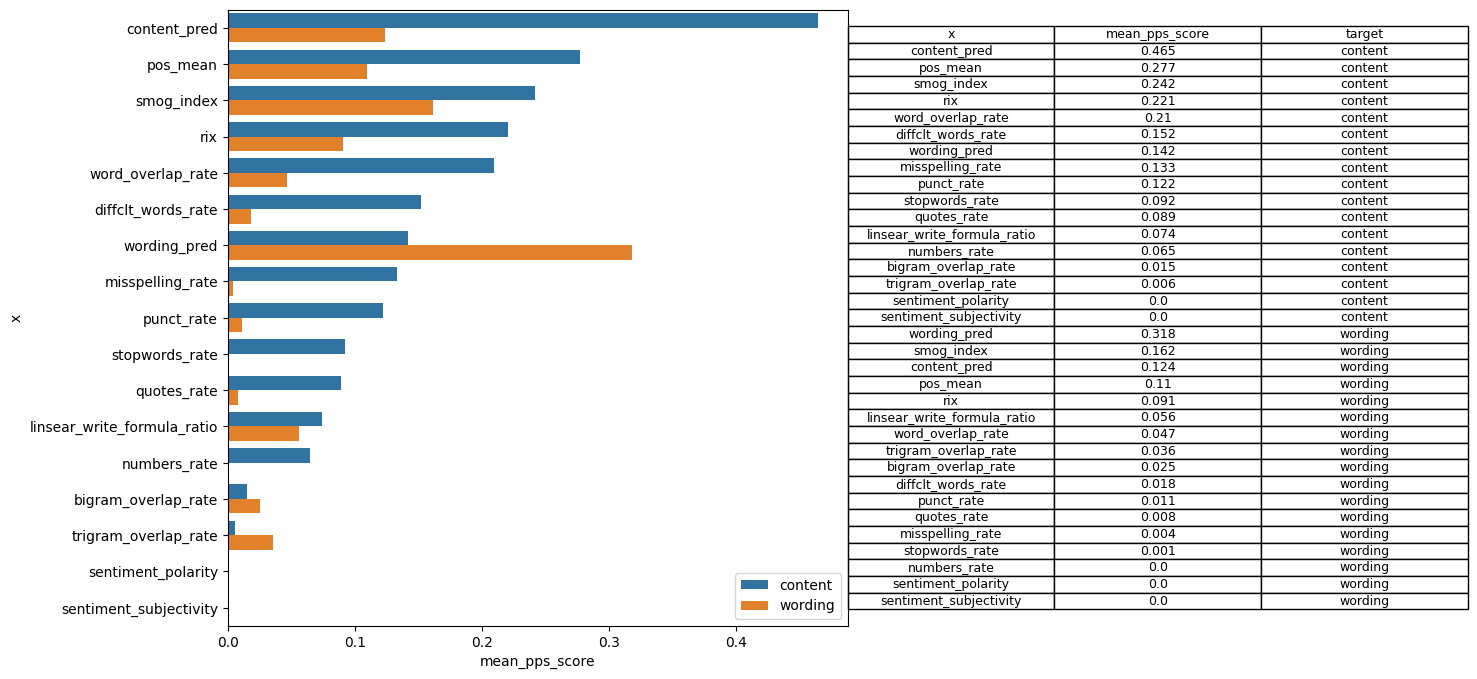

In [263]:
pps_predictors_cv = pd.DataFrame()
for target in targets:
  import matplotlib.pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(8, 8))
  pps_target_predictors_cv  = get_target_mean_pps(target)
  pps_target_predictors_cv['target'] = target
  pps_predictors_cv = pd.concat([pps_predictors_cv, pps_target_predictors_cv] , axis = 0)
  pps_predictors_cv['mean_pps_score'] = pps_predictors_cv['mean_pps_score'].round(3)

columns = ["x", "mean_pps_score", "target"]
cell_text = []
ax = sns.barplot(data=pps_predictors_cv, y="x", x="mean_pps_score", hue = "target")
for i in range(len(pps_predictors_cv)):
    cell_text.append(pps_predictors_cv.iloc[i][columns].tolist())

ax.table(cellText=cell_text, colLabels=columns, cellLoc='center', loc='right')

plt.legend(loc='lower right')

In [264]:
def get_input_mean_pps(target = None):
  pps_score_df = pd.concat([df['ppscore'] for df in pps_input_scores], axis=1)
  mean_pps_score = pps_score_df.mean(axis=1)
  pps_matrix_cv = pps_input_scores[0][['x','y']].copy()
  pps_matrix_cv['mean_pps_score'] = mean_pps_score

  return pps_matrix_cv[['x', 'y', 'mean_pps_score']]

<Figure size 1500x2000 with 0 Axes>

<Axes: xlabel='x', ylabel='y'>

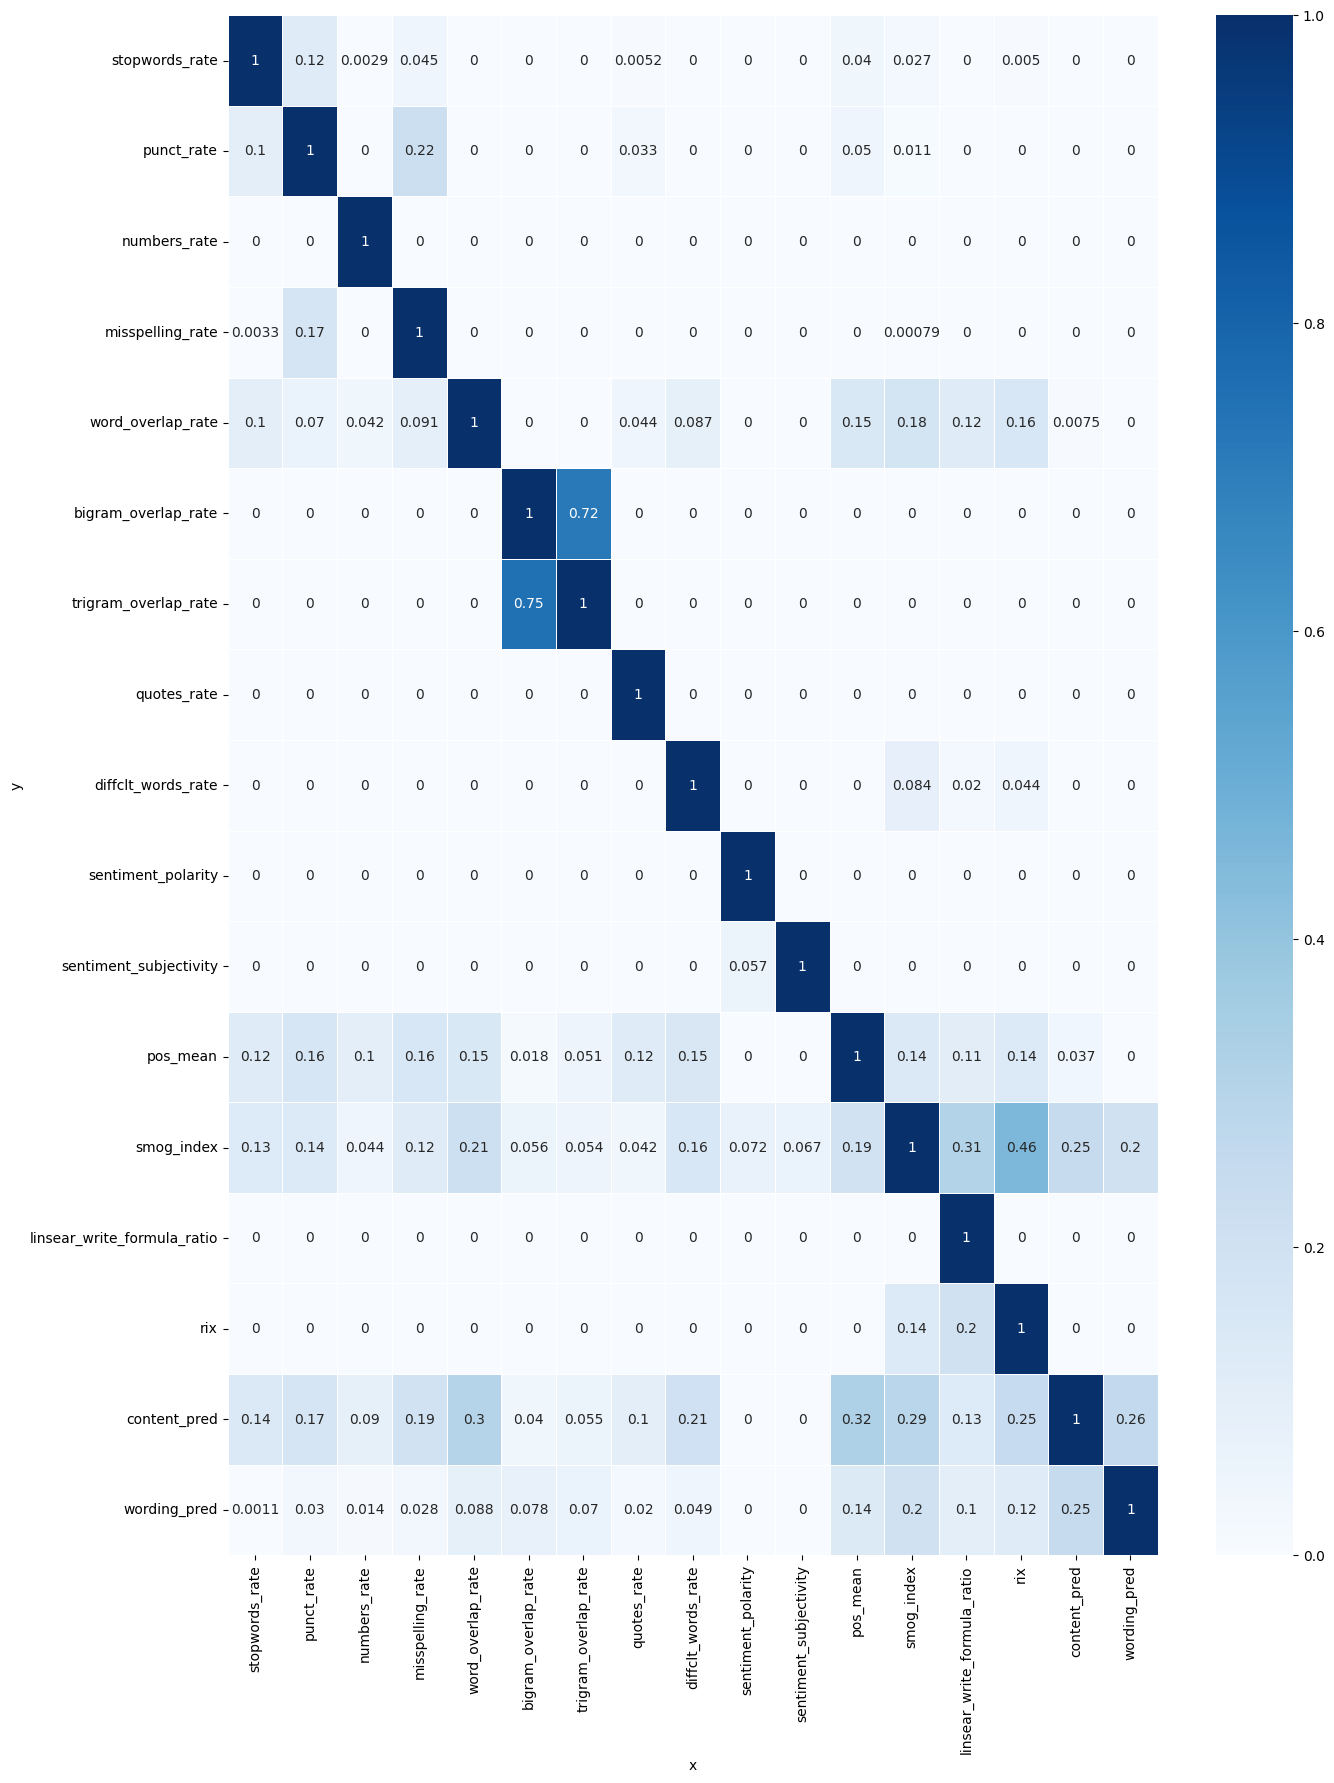

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 20))
pps_matrix_cv  = get_input_mean_pps(target)
pps_matrix_cv = pps_matrix_cv.pivot_table(columns='x', index='y', values='mean_pps_score', sort=False)
sns.heatmap(pps_matrix_cv, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

# Prediction

In [195]:
pred_dict = {}
for target in targets:
    models = model_dict[target]
    preds = []

    for fold, model in enumerate(models):
        X_eval_cv = test.drop(columns=drop_columns, errors='ignore')

        pred = model.predict(X_eval_cv)
        preds.append(pred)

    pred_dict[target] = preds

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 2>:9                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'int' object has no attribute 'predict'

In [ ]:
for target in targets:
    preds = pred_dict[target]
    for i, pred in enumerate(preds):
        test[f"{target}_pred_{i}"] = pred

    test[target] = test[[f"{target}_pred_{fold}" for fold in range(n_splits)]].mean(axis=1)

In [ ]:
submission_file = os.path.join(SYS_OUTPUT_DIR, "submission.csv")
test[["student_id", "content", "wording"]].to_csv(submission_file, index=False)